In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom, rv_continuous
import matplotlib.pyplot as plt
import random
import math

In [2]:
cutoff = 0.95 # The European norm for the required accuracy of the machine

# Classes

In [3]:
class Wafer:
    pass

In [4]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [5]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_pmf(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def plot_cdf(self, n):
        """Plot cdf of estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.cdf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.cdf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("cumulative density function")
        plt.show()

    # Testing with variable number of tests
    def test_advanced_95(self, max_tests):
        """Test the machine until it is 95% certain that the machine works or we reached the maximum number of tests.
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        min_tests = 50
        
        if max_tests < min_tests:
            min_tests = max_tests

        for n in range(1, min_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
        
        for n in range(min_tests + 1, max_tests + 1):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = Machine.wilson_score_interval_95(p_, n)
            
            if (left > cutoff and right > cutoff):
                return (p_, n)
            
            if (left < cutoff and right < cutoff):
                return (p_, n)
                   
        return (p_, n)
    
    def calculate_interval(certainty, p_, n):
        """Incorrect implementation, use wilson_score_interval_95 instead"""
        error = (1 - certainty) / 2
        
        # Bounds expressed in successes
        leftS = binom.ppf(error, n, p_)
        rightS = binom.ppf(1 - error, n, p_)
        
        # Express in p_
        return (leftS / n, rightS / n)

    
    def wilson_score_interval_95(p_, n):
        """Returns (the Wilson approximation of) the interval such that it is 95% certain that after n tests
        the actual probability of the machine lies in this interval"""
        # From https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
        z = 1.96 # for 95% confidence
        
        base = (p_ + z**2/(2*n))/(1+z**2/n)
        spread = z/(1+z**2/n) * math.sqrt((p_*(1-p_))/n + z**2/(4*n**2))
        
        left = base - spread
        right = base + spread
        
        return (left, right)
        
    def procedure_basic(self, n):
        """This basic procedure uses the test_basic to approximate the accuracy of the machine.
        The basic test takes n wafers and returns the ratio (=p_) of working wafers"""
        return self.test_basic(n) >= cutoff
    
    def procedure_advanced_95(self, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(max_tests)
        return p_ >= cutoff
    
    def procedure_trivial(self):
        # This testing procedure basically doesn't test, but accepts all machines
        # Used for cost computation purposes
        return True


In [6]:
class double_trunc_norm_gen(rv_continuous):
    # Doesn't work for generating rvs, but still useful for plotting
    "Double truncated normal"
    def _pdf(self, x, mu1, sigma1, mu2, sigma2, step):
        return step * truncnorm.pdf(x, -mu1 / sigma1, (1 - mu1) / sigma1, loc=mu1, scale=sigma1) \
             + (1-step) * truncnorm.pdf(x, -mu2 / sigma2, (1 - mu2) / sigma2, loc=mu2, scale=sigma2)

In [7]:
double_trunc_norm = double_trunc_norm_gen(name="double truncated normal")

In [8]:
class Factory:
    def __init__(self, mu, sigma):
        """Factory that makes a machine with accuracies normally distributed."""
        self.mu = mu
        self.sigma = sigma
        
    def makeMachines(self, n):
        """Make machine"""
        ps = truncnorm(-self.mu / self.sigma, (1 - self.mu) / self.sigma, loc=self.mu, scale=self.sigma).rvs(n)
        return map(Machine, ps)
    
    def makeMachine(self):
        return self.makeMachines(1)[0]
    
    def test_testing_procedure(self, procedure, n): #onhandige naam maarja...
        """Test a procedure on machines normally distributed with mu sigma (truncated) n times.
        Procedure is a function that takes a machine and returns whether the machine works correctly."""
        successes = 0
        costs = 0
        time = 0
        
        machines = self.makeMachines(n)

        for m in machines:
            # if procedure gives correct result
            if procedure(m) == (m.p >= cutoff):
                successes += 1

            costs += m.costs
            time += m.runtime

        costs /= n
        time /= n

        print(f"Testing procedure was accurate {successes/n*100}% of the time.")

        days = time // (24 * 60)
        hours = (time % (24 * 60)) // 60
        minutes = (time % (24 * 60)) % 60
        rcosts = round(costs, 2)

        print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
        print("The costs associated with this test procedure is on average €" + str(rcosts))

In [9]:
class AltFactory(Factory):
    def __init__(self, mu1, sigma1, mu2, sigma2, step):
        """Factory that makes a machine with accuracies taken from two normal distributions, truncated between 0 and 1.
        With probability step from a truncated normal distribution around mu1 with deviation sigma1.
        With probability 1-step from a truncated normal distribution around mu2 with deviation sigma2.
        """
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.step = step
        
    def makeMachines(self, n):
        """Make machine"""
        if random.random() < self.step:
            mu = self.mu1
            sigma = self.sigma1
        else:
            mu = self.mu2
            sigma = self.sigma2
        ps = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(n)
        return map(Machine, ps)

# Playground

In [10]:
m = Machine(0.963)

In [11]:
p_ = m.test_basic(100)
print("Projected accuracy of machine:", p_)
m.get_stats()
m.reset()

Projected accuracy of machine: 0.97
Actual accuracy of machine: 0.963
It takes 0 day(s), 18 hour(s) and 23 minute(s) to test.
The costs associated with this test method is €448.57


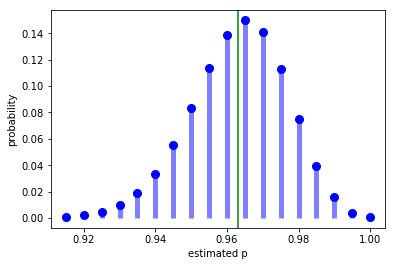

In [12]:
m.plot_pmf(200)

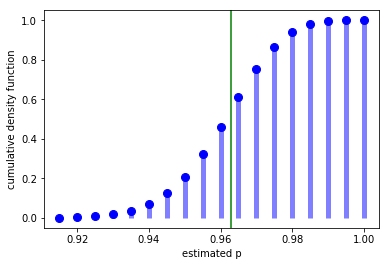

In [13]:
m.plot_cdf(200)

In [14]:
print(m.test_advanced_95(27))
m.reset()

(0.9230769230769231, 26)


---

In [15]:
Machine.wilson_score_interval_95(0.97, 500)

(0.9510959078150344, 0.9817369507659165)

In [16]:
Machine.calculate_interval(0.95, 0.97, 500)

(0.954, 0.984)

Nog niet zo'n slechte schatting

---

In [17]:
factory = Factory(0.98, 0.05)

In [18]:
factory.test_testing_procedure(lambda m : m.procedure_basic(500), 2000)

Testing procedure was accurate 92.95% of the time.
Test procedure took on average  3.0 day(s), 20.0 hour(s) and 4.336500000000342 minute(s).
The costs associated with this test procedure is on average €2242.86


Als de testing procedure bijvoorbeeld 90% van de keren klopt, is dat een heel **slecht** teken in dit geval. Alle machines goedkeuren bijvoorbeeld zou nog beter zijn, zie hieronder.



**Misschien moet de verdeling van de accuracy van de machines iets minder optimistisch?**<br>
zo beter?

In [19]:
factory.test_testing_procedure(Machine.procedure_trivial, 2000)

Testing procedure was accurate 58.9% of the time.
Test procedure took on average  0.0 day(s), 0.0 hour(s) and 0.0 minute(s).
The costs associated with this test procedure is on average €0.0


---

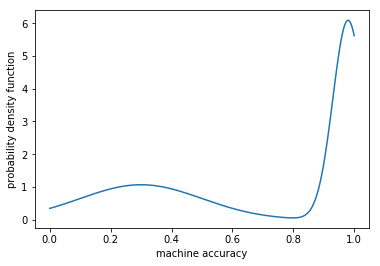

In [20]:
mu1 = 0.98
sigma1 = 0.05
mu2 = 0.3
sigma2 = 0.2

fig, ax = plt.subplots(1, 1)
x = np.arange(0, 1.001, 0.001)
ax.plot(x, double_trunc_norm.pdf(x, mu1, sigma1, mu2, sigma2, 0.5), label='double truncated normal pmf')
ax.set_xlabel("machine accuracy")
ax.set_ylabel("probability density function")
plt.show()

In [21]:
# DOESN'T WORK
# double_trunc_norm.ppf(0.1, mu1, sigma1, mu2, sigma2, 0.5)

# Proper Testing

In [22]:
def basic(n):
    return lambda m : m.procedure_basic(n)

In [23]:
def advanced(max_n):
    return lambda m : m.procedure_advanced_95(max_n)

In [24]:
def test(factory):
    for n in range(100, 1100, 100):
        print(f"Basic({n})")
        factory.test_testing_procedure(basic(n), 2000)
        print()

    for n in range(100, 1100, 100):
        print(f"Advanced({n})")
        factory.test_testing_procedure(advanced(n), 2000)
        print()

    print("Trivial")
    factory.test_testing_procedure(Machine.procedure_trivial, 2000)

In [25]:
test(Factory(0.98, 0.05))

Basic(100)
Testing procedure was accurate 83.39999999999999% of the time.
Test procedure took on average  0.0 day(s), 18.0 hour(s) and 24.82199999999989 minute(s).
The costs associated with this test procedure is on average €448.57

Basic(200)
Testing procedure was accurate 87.7% of the time.
Test procedure took on average  1.0 day(s), 12.0 hour(s) and 49.60750000000007 minute(s).
The costs associated with this test procedure is on average €897.14

Basic(300)
Testing procedure was accurate 89.95% of the time.
Test procedure took on average  2.0 day(s), 7.0 hour(s) and 14.278999999999996 minute(s).
The costs associated with this test procedure is on average €1345.71

Basic(400)
Testing procedure was accurate 91.25% of the time.
Test procedure took on average  3.0 day(s), 1.0 hour(s) and 38.99300000000039 minute(s).
The costs associated with this test procedure is on average €1794.29

Basic(500)
Testing procedure was accurate 92.95% of the time.
Test procedure took on average  3.0 day(s)

In [26]:
test(AltFactory(0.98, 0.05, 0.3, 0.2, 0.98))

Basic(100)
Testing procedure was accurate 100.0% of the time.
Test procedure took on average  0.0 day(s), 19.0 hour(s) and 27.808500000000095 minute(s).
The costs associated with this test procedure is on average €448.57

Basic(200)
Testing procedure was accurate 87.2% of the time.
Test procedure took on average  1.0 day(s), 12.0 hour(s) and 49.751000000000204 minute(s).
The costs associated with this test procedure is on average €897.14

Basic(300)
Testing procedure was accurate 90.75% of the time.
Test procedure took on average  2.0 day(s), 7.0 hour(s) and 13.883499999999913 minute(s).
The costs associated with this test procedure is on average €1345.71

Basic(400)
Testing procedure was accurate 92.10000000000001% of the time.
Test procedure took on average  3.0 day(s), 1.0 hour(s) and 39.68549999999959 minute(s).
The costs associated with this test procedure is on average €1794.29

Basic(500)
Testing procedure was accurate 92.30000000000001% of the time.
Test procedure took on avera